# Lecture 5.3: ARIMA Models 


** Reference **:  
* [Using R for Time Series Analysis](https://a-little-book-of-r-for-time-series.readthedocs.io/en/latest/src/timeseries.html)
* [Forecasting: principles and practice](https://www.otexts.org/fpp)

## What is ARIMA?  

* ARIMA models provide another approach to time series forecasting  

* ARIMA is an acronym for AutoRegressive Integrated Moving Average model

* ARIMA(p,d,q) consists of:
    * AR(p): persistence of history through AR terms
    * I(d): trend
    * MA(q): influence of past shocks through MA terms 
    * (Can add higher order lags for seasonality)

### Brief Overview of the Methodology  

* The Box-Jenkins Methodology applies autoregressive moving average models to find the best fit of a time series based on past values.  

**3-stage approach**:  
1. Model Identification
    * Making sure data is stationary
    * Identifying seasonality
    * Using plots of autocorrelation (ACF) and partial autocorrelation (PACF) to decide which autoregressive and/or moving average components to include
2. Parameter Estimation via MLE or non-linear least squares
3. Model Checking by testing the model residuals  

If estimation is inadequate, we return to step 1 and iterate.

## Stationary Time Series  

A stationary time series is one for which the statistical behavior of a set of observations $y_{t_1}, y_{t_2}, \dots, y_{t_k}$ is identical to that of the shifted set of observations $y_{t_{1+h}}, y_{t_{2+h}}, \dots, y_{t_{k+h}}$ for any collection of time points $t_1, t_2, \dots, t_k$ and for any shift $h$ (lag).  

This is the definition of strong stationarity and is too strong for most applications.  

### Weak Stationarity  

There is a relaxed definition, referred to as weak stationarity which requires only that the first and second moments satisfy the following constraints:  


$$ E(y_t) = \mu \text{ for all } t $$  


$$ \gamma_y (h) = E[(y_{t+h} - \mu)(y_t - \mu)] $$  

where $E$ is the usual expectation over the population density, $h$ is the time shift (lag), and  $\gamma_y (h)$ is called the **autocovariance function** and we additionally assert that  

$$\gamma_y (h) = \gamma_y (-h) $$  

In general, a stationary time series will have no predictable patterns in the long-term. 

#### white noise

* $\gamma_y (h) = Var(y_t)$ iff $h = 0$, and 0 otherwise
* is (weakly) stationary
* is a key building block of time series models

### Assessing Stationarity  

Box-Jenkins models describe stationary time series, so we must
determine if the series is stationary and if not, transform it to
attain stationarity.  

* We can plot the time series data to check for any obvious trend, seasonality or change in variance

* We can use the ACF to determine if the time series is stationary    

    * If the ACF dies down quickly (relatively few significant lags) we can consider the series stationary
    * If it dies down slowly then we need to try some transformations to either remove the trend or stabilize the variance
    * We will then use the new transformed series as the "working" time series for the remainder of the analysis  

#### ACF and PACF  

* Autocorrelation Function (ACF)  
    * Measures correlation at adjacent points of the same series  
    
    $$ \rho_y (h) = \frac{\gamma_y (h)}{\gamma_y (0)} $$  
    
    $$ -1 < \rho_y (h) < 1 $$  
    
* Partial Autocorrelation Function (PACF) 
    * Gives the partial correlation of a time series with its own lagged values, controlling for the values of the time series at all shorter lags. 
    * It contrasts with the autocorrelation function, which does not control for other lags.
    * On can think of the PACF as the simple correlation between two points separated by a lag $h$, say $y_t$ and $y_{t-h}$, with the effect of the intervening points $y_{t-1}, y_{t-2}, \dots, y_{t-h+1}$ conditioned out.
    * At lag $h = 1$, PACF = ACF, since there is no data points between $y_t$ and $y_{t - 1}$
    * At lag $h = 2$, or the 2nd order PACF is  
    
    $$ \frac{Covariance(y_t, y_{t - 2} \ | \ y_{t - 1})}{\sqrt{Variance(y_t \ | \ y_{t - 1}) \ Variance(y_{t - 2} \ | \ y_{t - 1})}} $$

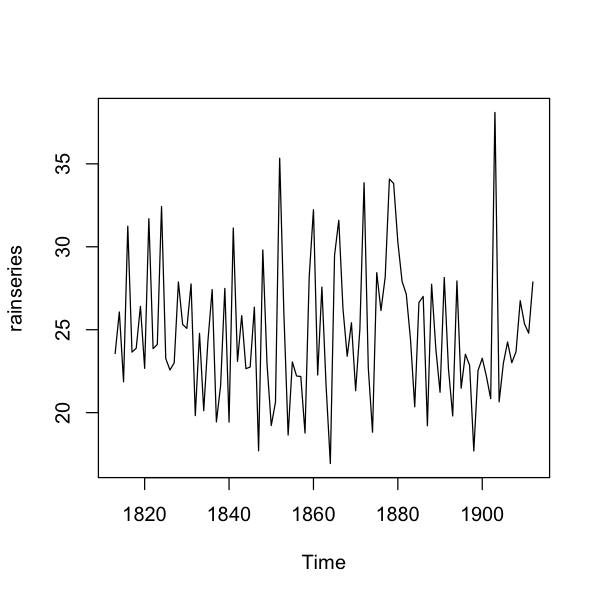

In [1]:
# The data contains total annual rainfall in inches for London, from 1813-1912
rain = scan("http://robjhyndman.com/tsdldata/hurst/precip1.dat",skip=1)
rainseries = ts(rain,start=c(1813))
options(repr.plot.height = 5, repr.plot.width = 5)
plot(rainseries)

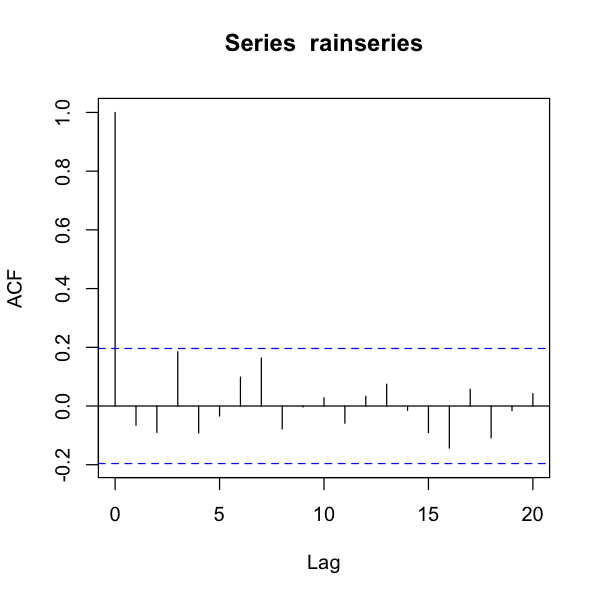

In [4]:
# You can use the 'acf' function which by default includes the ACF at lag 0
acf(rainseries)

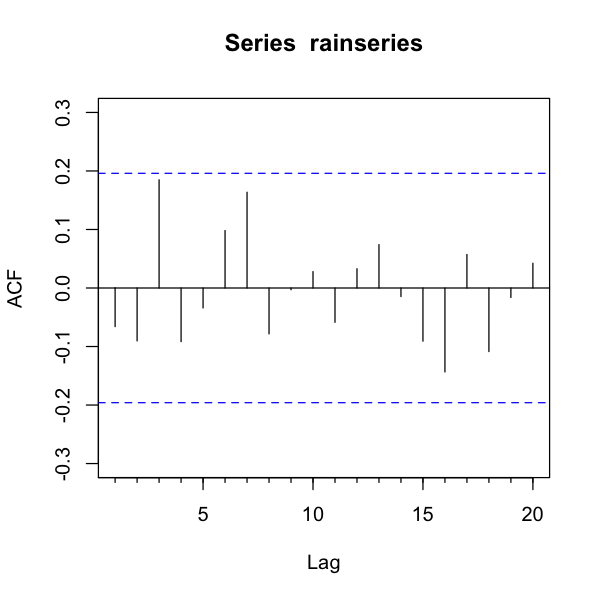

In [8]:
# Or you can use the 'Acf' function from the "forecast" library
# Which doesn't include lag 0 by default
library("forecast")
Acf(rainseries)

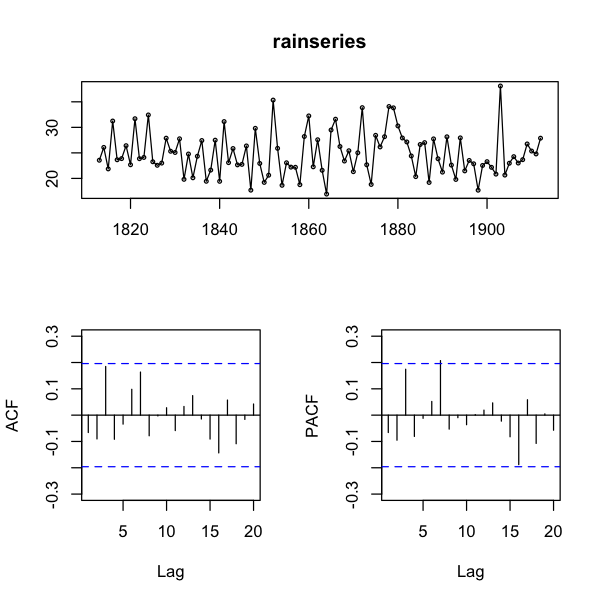

In [9]:
# Or you can plot everything all at once
tsdisplay(rainseries)

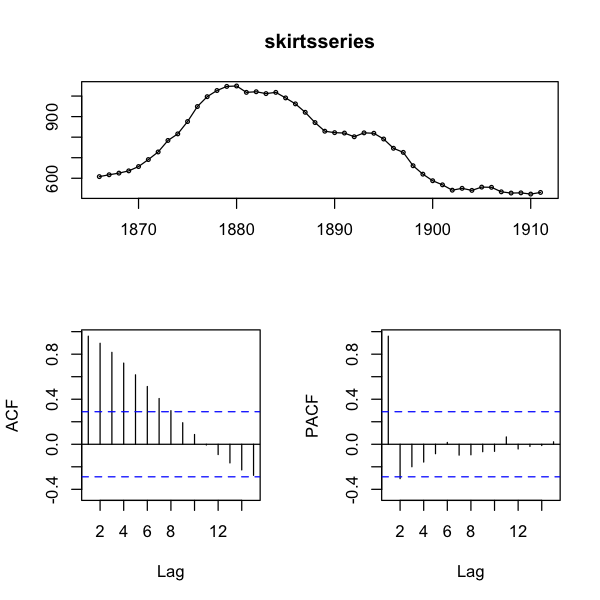

In [10]:
# The data contains the annual diameter of women’s skirts at the hem, from 1866 to 1911
skirts = scan("http://robjhyndman.com/tsdldata/roberts/skirts.dat",skip=5)
skirtsseries = ts(skirts,start=c(1866))
tsdisplay(skirtsseries)

### Nonstationarity  

So time series with trends, or with seasonality, are not stationary — the trend and seasonality will affect the value of the time series at different times.  

Most time series are not stationary to begin with, so we need to modify the series to improve the approximation of stationarity by  

* Detrending
* Differencing
* Transformations 

### Detrending  

The general version of a nonstationary time series is to assume
a general linear trend of the form  

$$ y_t = \beta_0 + \beta_1 t + \varepsilon_t  $$  

The natural thing to do is to consider the residual  

$$\hat{e}_t = y_t - \hat{\beta}_0 - \hat{\beta}_1 t $$  

as a plausible stationary series where $\beta_0$ and $\beta_1$ are the 
estimated intercept and slope coefficients based on least squares estimation.

### Differencing  

A common first step for achieving stationarity is with the first difference
$$ \nabla  y_t = y_t - y_{t-1} $$  


$ \nabla  y_t$ is useful for series with trend.    

Higher order differences are defined as successive applications of the operator 5. For example, the second difference is  

$$ \nabla^2 y_t = \nabla[\nabla y_t] = [y_t - y_{t - 1}] - [y_{t - 1} - y_{t - 2}] $$  

If the model also contains a quadratic trend term, $ \nabla^2 y_t$ usually
reduces the model to a stationary form.

#### Seasonal Differencing  

We can also take a “lag-$m$ difference” by subtract the observation after a lag of $m$ periods:  

$$ \nabla_m  y_t = y_t - y_{t-m} $$


#### Unit Root Tests

* We can determine if differencing is required using unit root tests
* Two popular tests:
    * Augmented Dickey-Fuller (ADF) test
        * $H_0$: the data are non-stationary
        * $p < 0.05 \rightarrow $ differencing is NOT required
    * Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test
        * $H_0$: the data are stationary
        * $p < 0.05 \rightarrow $ differencing IS required

In [33]:
library("tseries")
adf.test(skirtsseries, alternative = "stationary")


	Augmented Dickey-Fuller Test

data:  skirtsseries
Dickey-Fuller = -3.3524, Lag order = 3, p-value = 0.07555
alternative hypothesis: stationary


In [32]:
kpss.test(skirtsseries)

Warning message in kpss.test(skirtsseries):
“p-value smaller than printed p-value”


	KPSS Test for Level Stationarity

data:  skirtsseries
KPSS Level = 1.0585, Truncation lag parameter = 1, p-value = 0.01


> A useful R function is `ndiffs()` which uses these tests to determine the appropriate number of first differences required for a non-seasonal time series.

> A useful R function for determining whether seasonal differencing is required is `nsdiffs()` which uses seasonal unit root tests to determine the appropriate number of seasonal differences required.

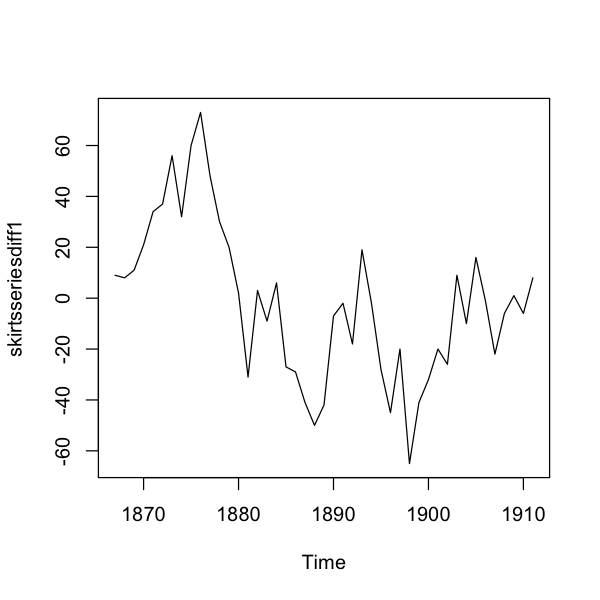

In [35]:
skirtsseriesdiff1 = diff(skirtsseries)
plot(skirtsseriesdiff1)

** Exercise **: Check if the differenced data is stationary. If not, try to modify the data further to improve stationarity.

In [34]:
# Check the appropriate number of first differences
ndiffs(skirtsseries)

[1] 2

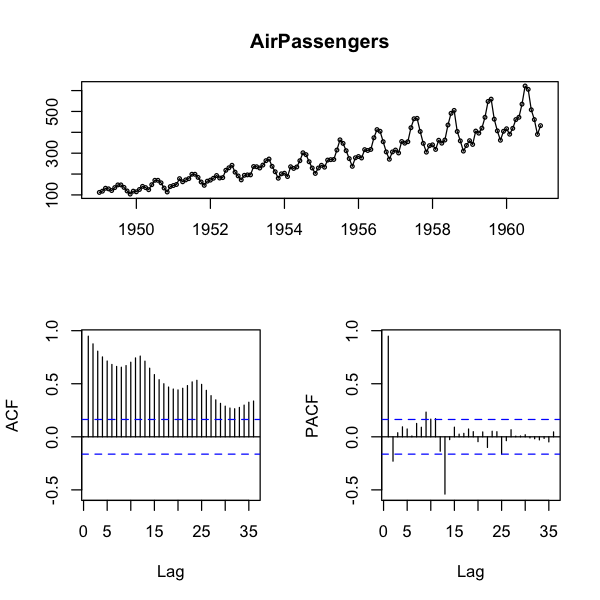

In [15]:
# Let's look at another example
data(AirPassengers)
tsdisplay(AirPassengers)

In [37]:
# Determine the appropriate number of seasonal differences
nsdiffs(AirPassengers)

[1] 1

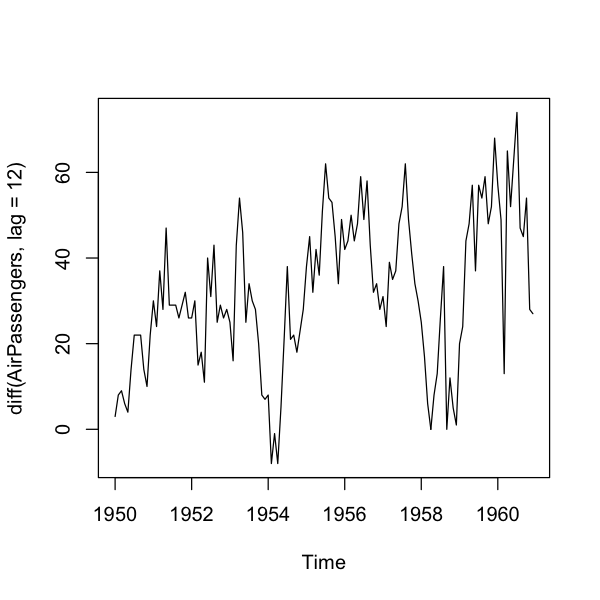

In [16]:
plot(diff(AirPassengers, lag = 12))

** Exercise ** : Is it stationary now? Try to make it more stationary.

### Transformations  

A transformation that cuts down the values of larger peaks of a
time series and emphasizes the lower values may be effective in
reducing nonstationary behavior due to changing variance.  

Examples:  

* The logarithmic transformation, $log (y_t )$ usually exponential-base (natural log)
* The square root transformation, $\sqrt{y_t}$, useful for count data  
* More general transformations fall within the Box-Cox family

#### Box-Cox transformations

* A useful family of transformations that includes logarithms and power transformations  
* They depend on the parameter $\lambda$ and are defined as follows:  

$$
w_t = 
\begin{cases}
log(y_t) & \text{if } \lambda = 0 \\
(y_t^{\lambda} - 1) / \lambda & \text{otherwise }\\
\end{cases}
$$

* So if $\lambda = 0$, natural logarithms are used, but if $\lambda \neq 0$, a power transformation is used followed by some simple scaling.  

In [26]:
# The BoxCox.lambda() function will choose a value of lambda for you
lambda = BoxCox.lambda(AirPassengers) 
lambda

[1] -0.2947156

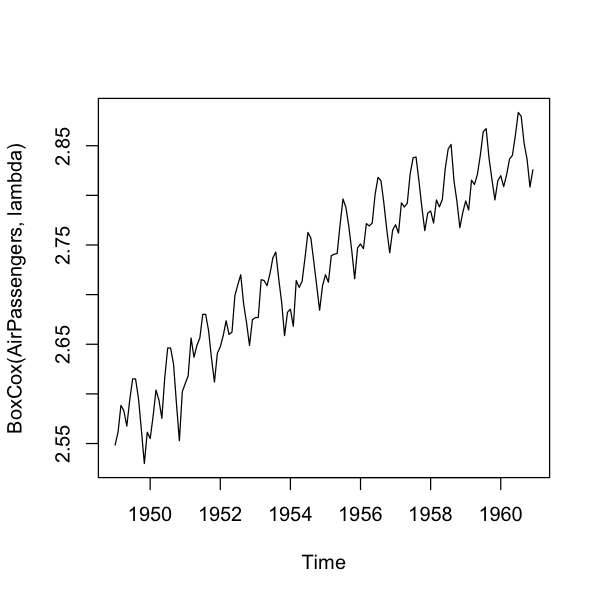

In [27]:
plot(BoxCox(AirPassengers, lambda))

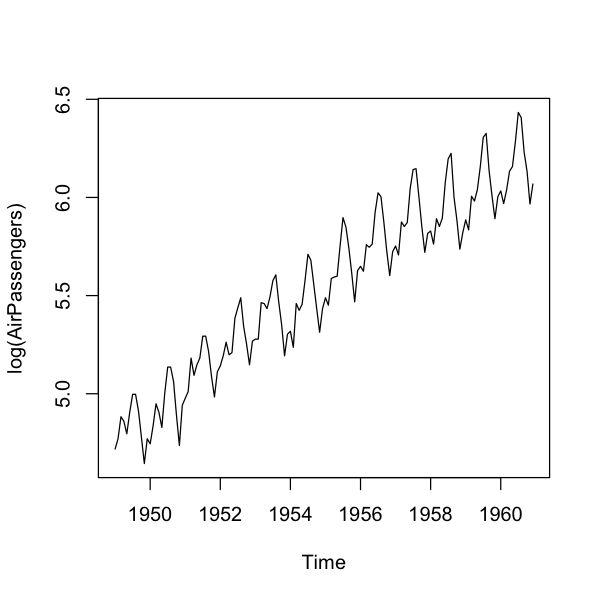

In [28]:
plot(log(AirPassengers))

**Note**: If we have chosen a transformation, we need to forecast the transformed data first. Then, we need to reverse the transformation (or back-transform) to obtain forecasts on the original scale.

## ARIMA  Modelling

An ARIMA(p, d, q) is a general model which includes AR, I, and MA:
* AR(p): AR of order p
* I(d): I of order d
* MA(q): MA of order q

**Remarks**:
* AR, I, and/or MA may be missing from a general ARIMA model
* May also include seasonal components . . . Specify as ARIMA (p, d, q)(P, D, Q)$_m$
* If d = 0 $\Rightarrow$ ARIMA becomes ARMA

**AR(p)**  

AR(p) means auto-regressive of order p:  

$$ y_t = c + \phi_1  y_{t−1} + \dots + \phi_p  y_{t−p} + \varepsilon_t $$

**MA(q)** 

An MA(q) model captures the persistence of past shocks.  

MA(q) means moving average of order q:  

$$ y_t = c + \varepsilon_t +  \theta_1  \varepsilon_{t−1} + \dots + \theta_q \varepsilon_{t - q} $$  

* Moving average models should not be confused with moving average smoothing we discussed yesterday 
    * A moving average model is used for forecasting future values 
    * Moving average smoothing is used for estimating the trend-cycle of past values

**Quiz**: Can you write an AR(1) model as a MA($\infty$)?

** I(d) ** 

An I(d) model captures the non-stationary trend.  

* I(d) means integrated of order d:
$$ y_t = y_{t−1} + \mu + \varepsilon_t $$  
* d is how many times you must difference the series so that it is stationary
* Usually, $d \in {0, 1, 2}$
* Differencing should remove the trend component

### Non-seasonal ARIMA models  

* If we combine differencing with autoregression and a moving average model, we obtain a non-seasonal ARIMA model  

* The full model can be written as  

$$ y_t' = c + \phi_1  y_{t−1} + \dots + \phi_p  y_{t−p} + \varepsilon_t +  \theta_1  \varepsilon_{t−1} + \dots + \theta_q \varepsilon_{t - q}$$

* where $y_t'$ is the differenced series  

* The "predictors" include both lagged values of $y_t$ and lagged errors

### Selecting a Candidate ARIMA Model  

* Once the data is stationary, the next step is to select the appropriate ARIMA model
* Which means finding the values of most appropriate values of p and q for an ARIMA(p,d,q) model
* To do this, we usually need to examine the correlogram and partial correlogram of the stationary time series  

> If the data are from an ARIMA(p,d,0) or ARIMA(0,d,q) model, then the ACF and PACF plots can be helpful in determining the value of p or q. If both p and q are positive, then the plots do not help in finding suitable values of p and q.

> The data may follow an ARIMA(p,d,0) model if the ACF and PACF plots of the differenced data show the following patterns:

> * the ACF is exponentially decaying or sinusoidal;
> * there is a significant spike at lag p in PACF, but none beyond lag p.

> The data may follow an ARIMA(0,d,q) model if the ACF and PACF plots of the differenced data show the following patterns:

> * the PACF is exponentially decaying or sinusoidal;
> * there is a significant spike at lag q in ACF, but none beyond lag q.

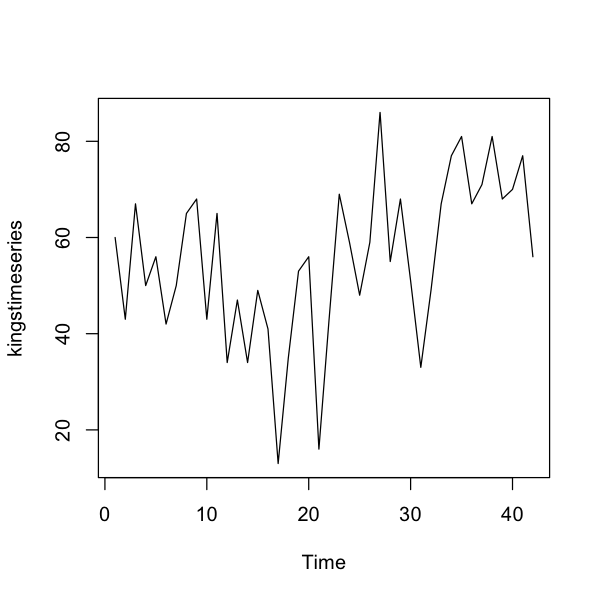

In [39]:
# Let's look at the following data as an example  

# The contains data on the age of death of successive kings of England
# starting with William the Conqueror

kings = scan("http://robjhyndman.com/tsdldata/misc/kings.dat",skip=3)
kingstimeseries = ts(kings)
plot(kingstimeseries)

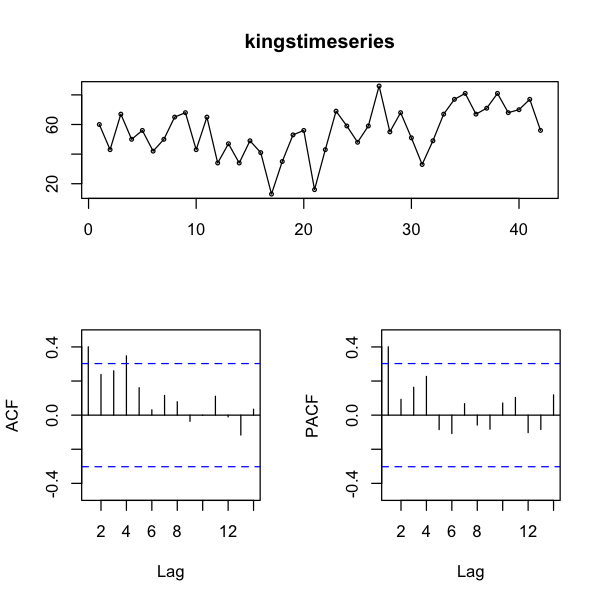

In [41]:
tsdisplay(kingstimeseries)

In [40]:
ndiffs(kingstimeseries)

[1] 1

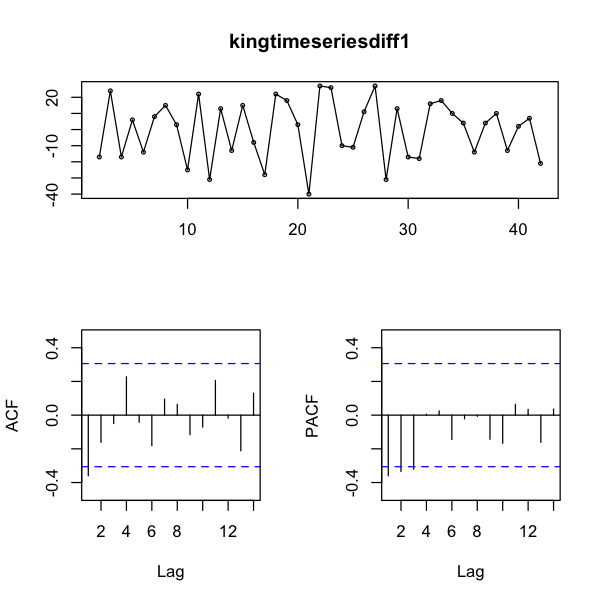

In [43]:
kingtimeseriesdiff1 = diff(kingstimeseries, differences=1)
tsdisplay(kingtimeseriesdiff1)

* The ACF is zero after lag 1, and the PACF tails off to zero after lag 3
* Possible models:
    * ARMA(3, 0)
    * ARMA(0, 1) 
    * ARMA(p, q) 

In [44]:
kingstimeseriesarima = Arima(kingstimeseries, order=c(0,1,1))
kingstimeseriesarima

Series: kingstimeseries 
ARIMA(0,1,1)                    

Coefficients:
          ma1
      -0.7218
s.e.   0.1208

sigma^2 estimated as 236.2:  log likelihood=-170.06
AIC=344.13   AICc=344.44   BIC=347.56

**Note**: In R, the ARIMA model coefficients are estimated using maximum likelihood estimation (MLE).

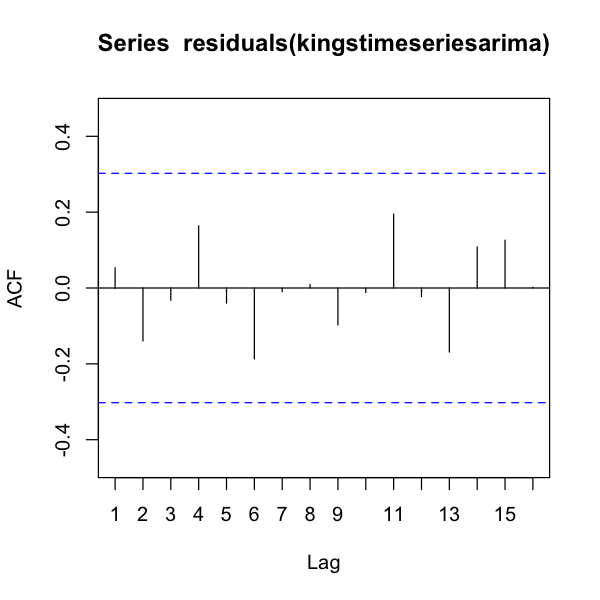

In [47]:
Acf(residuals(kingstimeseriesarima))

In [74]:
Box.test(residuals(kingstimeseriesarima), lag=24, type="Ljung-Box")


	Box-Ljung test

data:  residuals(kingstimeseriesarima)
X-squared = 17.74, df = 24, p-value = 0.8154


### Information Criteria  

* Akaike’s Information Criterion (AIC)  

$$ AIC=−2log(L)+2(p+q+k+1) $$

where $L$ is the likelihood of the data, $k=1$ if $c \neq 0$ and $k=0$ if $c=0$  

* For ARIMA models, the corrected AIC  

$$ AIC_c=AIC+\frac{2(p+q+k+1)(p+q+k+2)}{T−p−q−k−2}$$  

* Bayesian Information Criterion(BIC)  

$$ BIC=AIC+(log(T)−2)(p+q+k+1) $$

**Exercise**: Try a few other plausible ARIMA models and find the best one by comparing the AIC, AIC$_c$ or BIC.

### Forecasting  

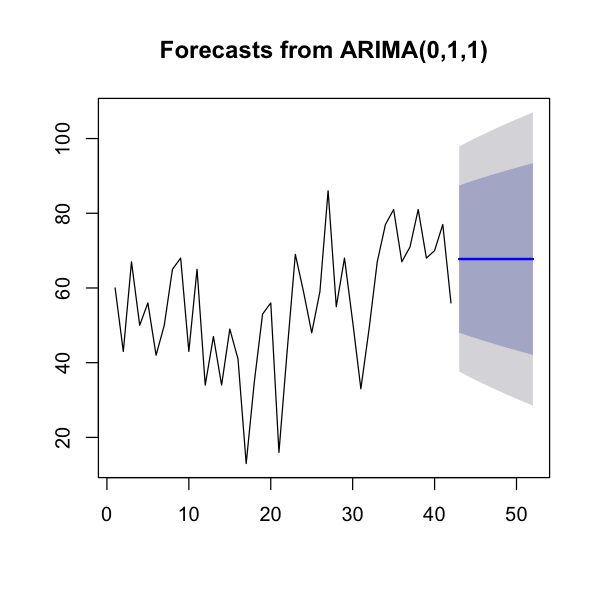

In [51]:
plot(forecast(kingstimeseriesarima, h = 10))

#### auto.arima()  

In R, The `auto.arima()` function can select the appropriate values for p, d and q for you automatically.

In [52]:
fit = auto.arima(kingstimeseries, seasonal=FALSE)
summary(fit)

Series: kingstimeseries 
ARIMA(0,1,1)                    

Coefficients:
          ma1
      -0.7218
s.e.   0.1208

sigma^2 estimated as 236.2:  log likelihood=-170.06
AIC=344.13   AICc=344.44   BIC=347.56

Training set error measures:
                    ME     RMSE      MAE       MPE    MAPE      MASE       ACF1
Training set 0.9712931 14.99836 11.92162 -10.40664 29.5176 0.7496724 0.05350284


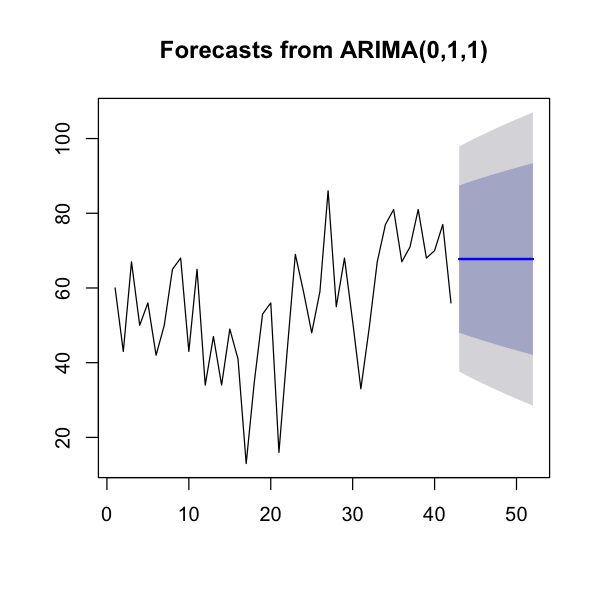

In [53]:
plot(forecast(fit,h=10))

### Modelling procedure  

>When fitting an ARIMA model to a set of time series data, the following procedure provides a useful general approach.

> 1. Plot the data. Identify any unusual observations.
> 2. If necessary, transform the data (using a Box-Cox transformation) to stabilize the variance.
> 3. If the data are non-stationary: take first differences of the data until the data are stationary.
> 4. Examine the ACF/PACF: Is an AR(p) or MA(q) model appropriate?
> 5. Try your chosen model(s), and use the AIC$_c$ to search for a better model.
> 6. Check the residuals from your chosen model by plotting the ACF of the residuals, and doing a portmanteau test of the residuals. If they do not look like white noise, try a modified model.
> 7. Once the residuals look like white noise, calculate forecasts.

**Modeling Flow Fhart from Hyndman et al.**

<img src="images/arima.png" width="700"> 

### Seasonal ARIMA Models  

* A seasonal ARIMA model is formed by including additional seasonal terms in the ARIMA models
* It is written as ARIMA (p, d, q) (P, D, Q)$_m$

> ACF/PACF
The seasonal part of an AR or MA model will be seen in the seasonal lags of the PACF and ACF. For example, an ARIMA(0,0,0)(0,0,1)$_{12}$ model will show:

> * a spike at lag 12 in the ACF but no other significant spikes.
> * The PACF will show exponential decay in the seasonal lags; that is, at lags 12, 24, 36, ….

> Similarly, an ARIMA(0,0,0)(1,0,0)$_{12}$ model will show:

> * exponential decay in the seasonal lags of the ACF
> * a single significant spike at lag 12 in the PACF.

> In considering the appropriate seasonal orders for an ARIMA model, restrict attention to the seasonal lags. The modelling procedure is almost the same as for non-seasonal data, except that we need to select seasonal AR and MA terms as well as the non-seasonal components of the model. The process is best illustrated via examples.



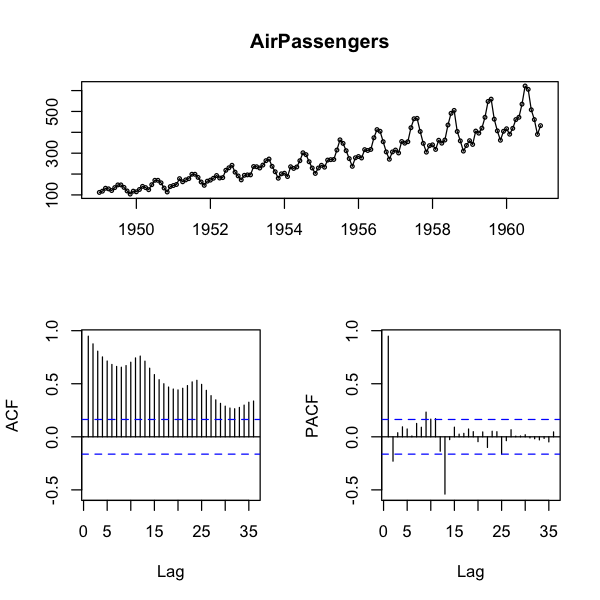

In [54]:
tsdisplay(AirPassengers)

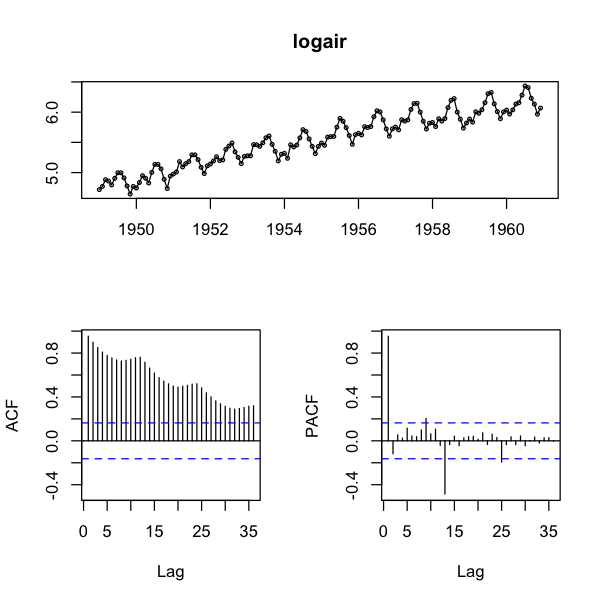

In [81]:
logair = log(AirPassengers)
tsdisplay(logair)

In [82]:
nsdiffs(logair)

[1] 1

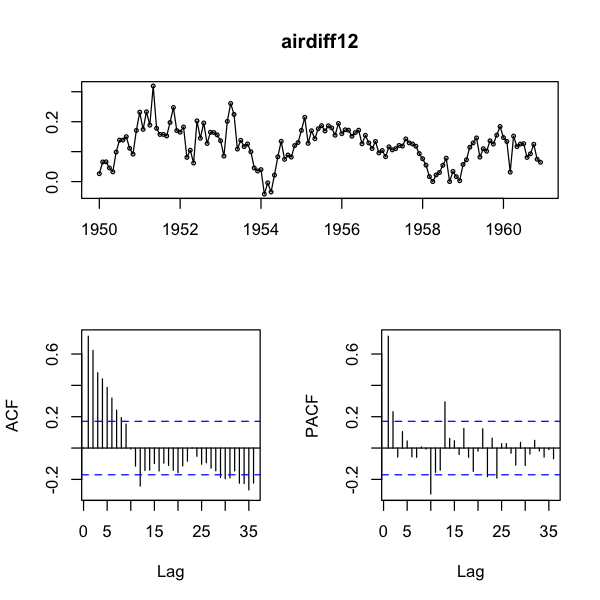

In [83]:
airdiff12 = diff(logair, lag = 12)
tsdisplay(airdiff12)

In [84]:
ndiffs(airdiff12)

[1] 1

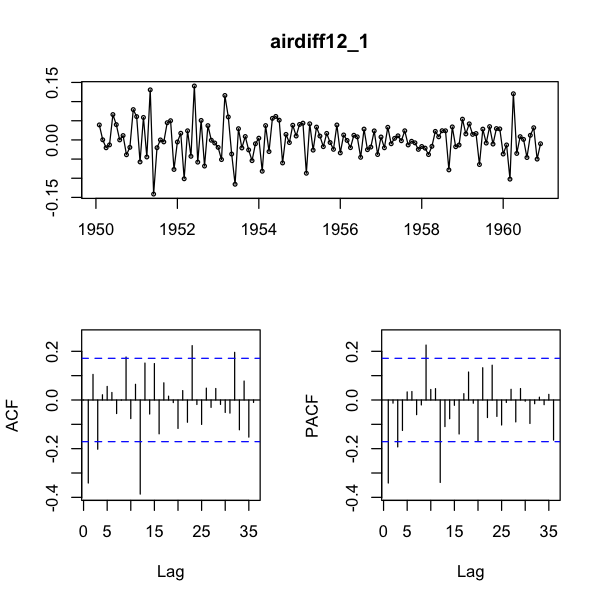

In [85]:
airdiff12_1 = diff(airdiff12)
tsdisplay(airdiff12_1)

In [86]:
airfit = Arima(AirPassengers, order=c(0,1,1), seasonal=c(0,1,1))
summary(airfit)

Series: AirPassengers 
ARIMA(0,1,1)(0,1,1)[12]                    

Coefficients:
          ma1     sma1
      -0.3087  -0.1074
s.e.   0.0890   0.0828

sigma^2 estimated as 137.5:  log likelihood=-507.5
AIC=1021   AICc=1021.19   BIC=1029.63

Training set error measures:
                    ME     RMSE      MAE        MPE     MAPE      MASE
Training set 0.3235529 11.09952 8.162425 0.04409006 2.897135 0.2548345
                     ACF1
Training set -0.003747514


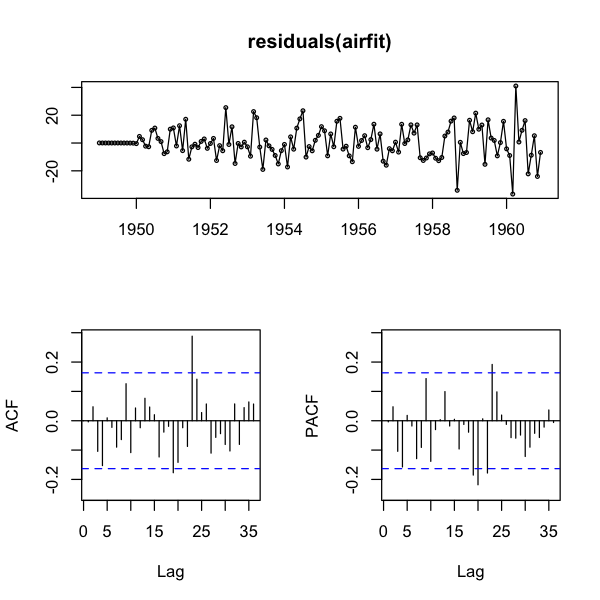

In [87]:
tsdisplay(residuals(airfit))

In [88]:
Box.test(residuals(airfit), lag=20, type="Ljung-Box")


	Box-Ljung test

data:  residuals(airfit)
X-squared = 25.011, df = 20, p-value = 0.201


**Exercise**: Try a few other plausible Seasonal ARIMA models and find the best one by comparing the AIC, AIC$_c$ or BIC.

In [89]:
airfit2 = auto.arima(logair)
summary(airfit2)

Series: logair 
ARIMA(0,1,1)(0,1,1)[12]                    

Coefficients:
          ma1     sma1
      -0.4018  -0.5569
s.e.   0.0896   0.0731

sigma^2 estimated as 0.001371:  log likelihood=244.7
AIC=-483.4   AICc=-483.21   BIC=-474.77

Training set error measures:
                       ME       RMSE        MAE        MPE      MAPE      MASE
Training set 0.0005730622 0.03504883 0.02626034 0.01098898 0.4752815 0.2169522
                   ACF1
Training set 0.01443892


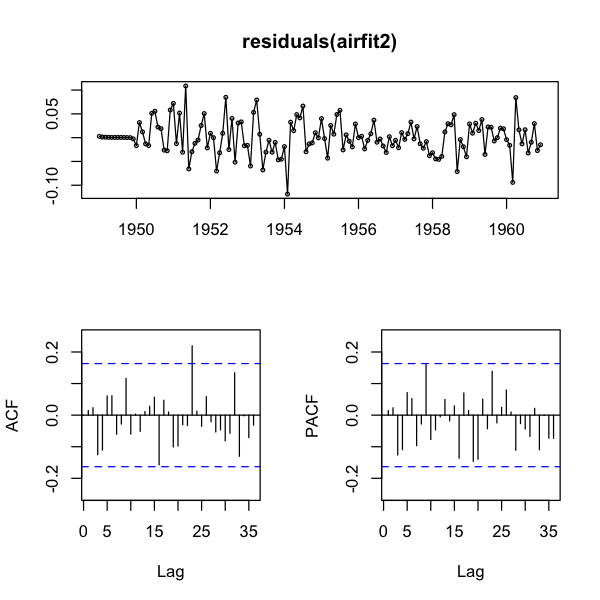

In [90]:
tsdisplay(residuals(airfit2))

In [91]:
Box.test(residuals(airfit2), lag=20, type="Ljung-Box")


	Box-Ljung test

data:  residuals(airfit2)
X-squared = 17.688, df = 20, p-value = 0.6079


**Exercise**: In RStudio, install the [fpp](https://cran.r-project.org/web/packages/fpp/) library, and try to fit a best Seasonal ARIMA model to the `h02` data set. (`auto.arima()` may or may not give you the best model.)